# Yelp Regression Model

In [2]:
%matplotlib inline
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import figure, show
from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam, SGD


2024-09-25 00:05:10.455516: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Professor's Functions

In [9]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

### Import Business and Review Data

In [5]:
# Convert Data from JSON to Pandas
reviews = pd.read_json('yelp_academic_dataset_review.json', lines=True, nrows=1000000)

business = pd.read_json('yelp_academic_dataset_business.json', lines=True, nrows=1000000)

# Rename to distinguish star ratings after join
reviews = reviews.rename(columns={'stars': 'review_rating'})
business = business.rename(columns={'stars': 'business_rating'})


In [6]:
# Add Location Column
business['location'] = business['city'] + ", " + business['state']

# Filter businesses out (review_count < 20 and null business_id & review_count)
business =  business[business.review_count > 20]

Before (59699, 15)
After (59699, 15)


In [7]:
# Merge the business and reviews together 
all_reviews = pd.merge(reviews,business, on='business_id') 

print(all_reviews.columns)
all_reviews.head()
# all_reviews.head()

Index(['review_id', 'user_id', 'business_id', 'review_rating', 'useful',
       'funny', 'cool', 'text', 'date', 'name', 'address', 'city', 'state',
       'postal_code', 'latitude', 'longitude', 'business_rating',
       'review_count', 'is_open', 'attributes', 'categories', 'hours',
       'location'],
      dtype='object')


,review_id,user_id,business_id,review_rating,useful,funny,cool,text,date,name,...,postal_code,latitude,longitude,business_rating,review_count,is_open,attributes,categories,hours,location
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,Turning Point of North Wales,...,19454,40.210196,-75.223639,3.0,169,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'...","North Wales, PA"
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18,Body Cycle Spinning Studio,...,19119,39.952103,-75.172753,5.0,144,0,"{'BusinessAcceptsCreditCards': 'True', 'GoodFo...","Active Life, Cycling Classes, Trainers, Gyms, ...","{'Monday': '6:30-20:30', 'Tuesday': '6:30-20:3...","Philadelphia, PA"
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30,Kettle Restaurant,...,85713,32.207233,-110.980864,3.5,47,1,"{'RestaurantsReservations': 'True', 'BusinessP...","Restaurants, Breakfast & Brunch",None,"Tucson, AZ"
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,Zaika,...,19114,40.079848,-75.025080,4.0,181,1,"{'Caters': 'True', 'Ambience': '{'romantic': F...","Halal, Pakistani, Restaurants, Indian","{'Tuesday': '11:0-21:0', 'Wednesday': '11:0-21...","Philadelphia, PA"
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,Melt,...,70119,29.962102,-90.087958,4.0,32,0,"{'BusinessParking': '{'garage': False, 'street...","Sandwiches, Beer, Wine & Spirits, Bars, Food, ...","{'Monday': '0:0-0:0', 'Friday': '11:0-17:0', '...","New Orleans, LA"


In [42]:
# Combine all the business's reviews into one text
business_reviews = all_reviews.groupby('business_id')['text'].sum()

# # Create a dataframe with the business and its all its cooresponding reviews
df_business_reviews = pd.DataFrame({
  'business_id' : business_reviews.index, 
  'all_reviews' : business_reviews.values,
})

df_business_reviews = pd.merge(df_business_reviews, business[['business_id', 'location', 'review_count', 'business_rating']], on='business_id')

In [44]:
# One hot encoding for location
df_encoded = pd.get_dummies(df_business_reviews['location'])
df_business_reviews = pd.concat([df_encoded, df_business_reviews], axis=1)

# Drop location column now that one)
df_business_reviews.drop(['location'], axis=1, inplace=True)


# Replace nulls with mean and normalize review count for the business
missing_median(df_business_reviews, 'review_count')
encode_numeric_zscore(df_business_reviews, 'review_count')

df_business_reviews.head()

,"Abington Township, PA","Abington, PA","Affton, MO","Aldan, PA","Alton, IL","Ambler, PA","Antioch, TN","Apollo Beach, FL","Arabi, LA","Ardmore, PA",...,"Yeadon, PA","Zephyrhills, FL","Zionsville, IN","boise, ID","clearwater, FL","wilmington, DE",business_id,all_reviews,review_count,business_rating
0,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,--ZVrH2X2QXBFdCilbirsw,This place is sadly perm closed. I was hoping ...,-0.407142,4.5
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,--sXnWH9Xm6_NvIjyuA99w,Ich war das erste mal in Philadelphia und ich ...,-0.424863,4.0
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,-02xFuruu85XmDn2xiynJw,Dr. Curtis Dechant has an excellent chair-side...,0.047699,4.5
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,-06OYKiIzxsdymBMDAKZug,Had catalytic converters replaced on our Subur...,-0.395328,4.5
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,-06ngMH_Ejkm_6HQBYxB7g,I have an old main line that really should be ...,-0.448491,4.0


In [79]:
text = df_business_reviews['all_reviews']
text.head()

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english',max_features=1000,min_df=1)
# Fit and transform the aggregated reviews into a TF-IDF matrix
tfidf_wm = vectorizer.fit_transform(text)

# Retrieve the feature names (i.e., the vocabulary)
tfidf_tokens = vectorizer.get_feature_names_out()

# Create a DataFrame from the TF-IDF matrix for easier viewing
df_tfidfvect = pd.DataFrame(data=tfidf_wm.toarray(), columns=tfidf_tokens)

In [11]:
df_tfidfvect.head()

,00,000,00pm,10,100,1000,10am,10pm,11,11am,...,york,young,younger,yuck,yum,yummy,zero,zone,zoo,zucchini
0,0.010745,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.026259,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.001932,0.012100,0.0,0.0,0.0,0.0,0.0,...,0.0,0.002882,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.072024,0.0,0.0,0.000000,0.037985,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [80]:
# Combine x and y into a single DataFrame
df_combined = pd.concat([df_tfidfvect, df_business_reviews['business_rating']], axis=1)

# Use the to_xy function to convert the DataFrame to x and y arrays
x, y = to_xy(df_combined, 'business_rating')

# Now split the transformed data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

# Check the shape of the resulting arrays
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(9216, 1000) (9216,) (2304, 1000) (2304,)


## Model Testing

In [17]:
def model_tester(hidden_layers=[], activation_function='relu', optimizer='adam', batch_size=32, learning_rate=0.01, dropout_rate=0.0): 
  # Initialize Optimizers
  adam = optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
  sgd = optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)  

  model = Sequential()

  for i in hidden_layers: 
    model.add(Dense(i, activation=activation_function))
    if dropout_rate > 0 and i % 2 == 1:
      model.add(Dropout(dropout_rate))

  model.add(Dense(1))

  if optimizer == 'adam': 
    model.compile(loss='mean_squared_error', optimizer=adam)
  else: 
    model.compile(loss='mean_squared_error', optimizer=sgd)

  # Initialize ModelCheckpoint and EarlyStopping
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=1, mode='auto')
  checkpointer = ModelCheckpoint(filepath="dnn/best_weights1.keras", verbose=0, save_best_only=True)

  model.fit(
    x_train,y_train, validation_data=(x_test,y_test), 
    batch_size=batch_size, callbacks=[monitor, checkpointer],
    verbose=2,epochs=100
  )

  model.load_weights('dnn/best_weights1.keras') # load weights from best model

  # Predict and measure RMSE
  pred = model.predict(x_test)
  score = np.sqrt(metrics.mean_squared_error(pred,y_test))

  return (score, pred)

In [15]:
model_types = [
    # 3 Hidden Layers
    {'hidden_layers': [256, 128, 64], 'activation_function': 'relu', 'optimizer': 'adam', 'dropout_rate': 0.2, 'pred': None, 'rmse': None, 'learning_rate': 0.01, 'batch_size': 32}, 
    {'hidden_layers': [256, 128, 64], 'activation_function': 'sigmoid', 'optimizer': 'adam', 'dropout_rate': 0.2, 'pred': None, 'rmse': None, 'learning_rate': 0.01, 'batch_size': 32}, 
    {'hidden_layers': [256, 128, 64], 'activation_function': 'tanh', 'optimizer': 'adam', 'dropout_rate': 0.2, 'pred': None, 'rmse': None, 'learning_rate': 0.01, 'batch_size': 32}, 
    {'hidden_layers': [256, 128, 64], 'activation_function': 'relu', 'optimizer': 'sgd', 'dropout_rate': 0.2, 'pred': None, 'rmse': None, 'learning_rate': 0.01, 'batch_size': 32}, 
    {'hidden_layers': [256, 128, 64], 'activation_function': 'sigmoid', 'optimizer': 'sgd', 'dropout_rate': 0.2, 'pred': None, 'rmse': None, 'learning_rate': 0.01, 'batch_size': 32}, 
    {'hidden_layers': [256, 128, 64], 'activation_function': 'tanh', 'optimizer': 'sgd', 'dropout_rate': 0.2, 'pred': None, 'rmse': None, 'learning_rate': 0.01, 'batch_size': 32}, 

    # 4 Hidden Layers
    {'hidden_layers': [512, 256, 128, 64], 'activation_function': 'relu', 'optimizer': 'adam', 'dropout_rate': 0.2, 'pred': None, 'rmse': None, 'learning_rate': 0.001, 'batch_size': 32}, 
    {'hidden_layers': [512, 256, 128, 64], 'activation_function': 'sigmoid', 'optimizer': 'adam', 'dropout_rate': 0.2, 'pred': None, 'rmse': None, 'learning_rate': 0.001, 'batch_size': 32}, 
    {'hidden_layers': [512, 256, 128, 64], 'activation_function': 'tanh', 'optimizer': 'adam', 'dropout_rate': 0.2, 'pred': None, 'rmse': None, 'learning_rate': 0.001, 'batch_size': 32}, 
    {'hidden_layers': [512, 256, 128, 64], 'activation_function': 'relu', 'optimizer': 'sgd', 'dropout_rate': 0.2, 'pred': None, 'rmse': None, 'learning_rate': 0.001, 'batch_size': 32}, 
    {'hidden_layers': [512, 256, 128, 64], 'activation_function': 'sigmoid', 'optimizer': 'sgd', 'dropout_rate': 0.2, 'pred': None, 'rmse': None, 'learning_rate': 0.001, 'batch_size': 32}, 
    {'hidden_layers': [512, 256, 128, 64], 'activation_function': 'tanh', 'optimizer': 'sgd', 'dropout_rate': 0.2, 'pred': None, 'rmse': None, 'learning_rate': 0.001, 'batch_size': 32}, 

    # Variety of models with relu and sgd
    # 3 hidden layers
    {'hidden_layers': [512, 256, 128], 'activation_function': 'relu', 'optimizer': 'sgd', 'dropout_rate': 0.2, 'pred': None, 'rmse': None, 'learning_rate': 0.01, 'batch_size': 16},
    {'hidden_layers': [512, 256, 128], 'activation_function': 'relu', 'optimizer': 'sgd', 'dropout_rate': 0.2, 'pred': None, 'rmse': None, 'learning_rate': 0.01, 'batch_size': 32},

    # 4 hidden layers
    {'hidden_layers': [1024, 512, 256, 128], 'activation_function': 'relu', 'optimizer': 'sgd', 'dropout_rate': 0.2, 'pred': None, 'rmse': None, 'learning_rate': 0.01, 'batch_size': 16},
     {'hidden_layers': [1024, 512, 256, 128], 'activation_function': 'relu', 'optimizer': 'sgd', 'dropout_rate': 0.2, 'pred': None, 'rmse': None, 'learning_rate': 0.001, 'batch_size': 16},
    {'hidden_layers': [1024, 512, 256, 128], 'activation_function': 'relu', 'optimizer': 'sgd', 'dropout_rate': 0.2, 'pred': None, 'rmse': None, 'learning_rate': 0.001, 'batch_size': 32},

    # Custom hidden layers
    {'hidden_layers': [160, 80, 40, 20, 10, 5], 'activation_function': 'relu', 'optimizer': 'sgd', 'dropout_rate': 0.1, 'pred': None, 'rmse': None, 'learning_rate': 0.01, 'batch_size': 32},
    {'hidden_layers': [1024, 2048, 1024, 512, 1024, 256, 128], 'activation_function': 'relu', 'optimizer': 'sgd', 'dropout_rate': 0.2, 'pred': None, 'rmse': None, 'learning_rate': 0.01, 'batch_size': 32},
    {'hidden_layers': [1024, 2048, 516, 256, 128, 2048, 128, 256, 512, 2048], 'activation_function': 'relu', 'optimizer': 'sgd', 'dropout_rate': 0.2, 'pred': None, 'rmse': None, 'learning_rate': 0.01, 'batch_size': 32},
    {'hidden_layers': [4096, 1024, 256, 128, 64, 32], 'activation_function': 'relu', 'optimizer': 'sgd', 'dropout_rate': 0.4, 'pred': None, 'rmse': None, 'learning_rate': 0.01, 'batch_size': 32},
]

model_results = []

In [115]:
model_results = []

for model in model_types:
    hidden_layer = model['hidden_layers']
    activation_function = model['activation_function']
    optimizer = model['optimizer']
    dropout_rate = model['dropout_rate']
    learning_rate = model['learning_rate']
    batch_size = model['batch_size']
    
    results = model_tester(
        hidden_layers=hidden_layer, 
        learning_rate=learning_rate, 
        optimizer=optimizer,
        activation_function=activation_function, 
        dropout_rate=dropout_rate, 
        batch_size=batch_size
    )

    model_results.append(results)

Epoch 1/100
288/288 - 6s - loss: 0.4185 - val_loss: 0.1928 - 6s/epoch - 20ms/step
Epoch 2/100
288/288 - 2s - loss: 0.1794 - val_loss: 0.1793 - 2s/epoch - 7ms/step
Epoch 3/100
288/288 - 1s - loss: 0.1609 - val_loss: 0.1652 - 1s/epoch - 5ms/step
Epoch 4/100
288/288 - 1s - loss: 0.1318 - val_loss: 0.2071 - 1s/epoch - 4ms/step
Epoch 5/100
288/288 - 1s - loss: 0.1159 - val_loss: 0.1777 - 1s/epoch - 4ms/step
Epoch 5: early stopping
72/72 [==============================] - 0s 2ms/step
Epoch 1/100
288/288 - 3s - loss: 0.4095 - val_loss: 0.1600 - 3s/epoch - 10ms/step
Epoch 2/100
288/288 - 1s - loss: 0.1614 - val_loss: 0.1522 - 1s/epoch - 5ms/step
Epoch 3/100
288/288 - 1s - loss: 0.1436 - val_loss: 0.1544 - 1s/epoch - 4ms/step
Epoch 4/100
288/288 - 1s - loss: 0.1288 - val_loss: 0.1544 - 1s/epoch - 5ms/step
Epoch 4: early stopping
72/72 [==============================] - 0s 2ms/step
Epoch 1/100
288/288 - 3s - loss: 0.8578 - val_loss: 0.6453 - 3s/epoch - 10ms/step
Epoch 2/100
288/288 - 1s - loss: 

In [116]:
# Combine model types with model_results
for i, result in enumerate(model_results):
    model_types[i]['rmse'] = result[0]
    model_types[i]['pred'] = result[1]  


# Create a DataFrame
model_results = pd.DataFrame(model_types)

model_results

,hidden_layers,activation_function,optimizer,dropout_rate,pred,rmse,learning_rate,batch_size
0,"[256, 128, 64]",relu,adam,0.2,"[[3.0659337], [3.0850768], [3.7099075], [3.375...",0.406442,0.010,32
1,"[256, 128, 64]",sigmoid,adam,0.2,"[[2.8591], [3.111888], [4.1219554], [3.3229852...",0.390160,0.010,32
2,"[256, 128, 64]",tanh,adam,0.2,"[[2.7307565], [2.8398578], [4.0438614], [3.230...",0.419181,0.010,32
3,"[256, 128, 64]",relu,sgd,0.2,"[[2.7938712], [3.0363688], [3.9260564], [3.181...",0.379123,0.010,32
4,"[256, 128, 64]",sigmoid,sgd,0.2,"[[3.6356876], [3.6353858], [3.6358178], [3.635...",0.814821,0.010,32
5,"[256, 128, 64]",tanh,sgd,0.2,"[[3.0247226], [3.0311], [3.7575817], [2.995162...",0.412946,0.010,32
6,"[512, 256, 128, 64]",relu,adam,0.2,"[[3.1681595], [3.0768342], [3.589417], [3.2312...",0.409662,0.001,32
7,"[512, 256, 128, 64]",sigmoid,adam,0.2,"[[2.8237984], [3.0899308], [4.1797376], [3.250...",0.390158,0.001,32
8,"[512, 256, 128, 64]",tanh,adam,0.2,"[[2.851713], [3.1508033], [3.898393], [3.21256...",0.388847,0.001,32
9,"[512, 256, 128, 64]",relu,sgd,0.2,"[[2.9340086], [3.0584044], [3.8331156], [3.170...",0.393279,0.001,32


In [ ]:
# Get best model results
best = model_results[1]

print("Score (RMSE): {}".format(best[0]))
chart_regression(best[1].flatten(),y_test)

for i in range(5):
    print("{}. Business name: {}, Rating: {}, Predicted Rating: {}".format(i+1,business.iloc[i]['name'],y[i],best[1][i]))

## Restaurant Specific Model Testing

In [3]:
# Convert Data from JSON to Pandas
reviews = pd.read_json('yelp_academic_dataset_review.json', lines=True, nrows=1000000)

business = pd.read_json('yelp_academic_dataset_business.json', lines=True, nrows=1000000)

# Rename to distinguish star ratings after join
reviews = reviews.rename(columns={'stars': 'review_rating'})
business = business.rename(columns={'stars': 'business_rating'})

In [4]:
business['categories'].head()

0    Doctors, Traditional Chinese Medicine, Naturop...
1    Shipping Centers, Local Services, Notaries, Ma...
2    Department Stores, Shopping, Fashion, Home & G...
3    Restaurants, Food, Bubble Tea, Coffee & Tea, B...
4                            Brewpubs, Breweries, Food
Name: categories, dtype: object

In [5]:
# Add Location Column
business['location'] = business['city'] + ", " + business['state']

# Filter businesses out (review_count < 20 and null business_id & review_count)
business =  business[business.review_count > 20]

print("Before : ", business.shape)
business['is_restaurant'] = business['categories'].str.contains('Restaurants', case=False, na=False)
business =  business[business['is_restaurant'] == True]

print("After : ", business.shape)


Before :  (59699, 15)
After :  (33217, 16)


In [6]:
# Merge the business and reviews together 
all_reviews = pd.merge(reviews,business, on='business_id') 

print(all_reviews.columns)
all_reviews.head()
# all_reviews.head()

Index(['review_id', 'user_id', 'business_id', 'review_rating', 'useful',
       'funny', 'cool', 'text', 'date', 'name', 'address', 'city', 'state',
       'postal_code', 'latitude', 'longitude', 'business_rating',
       'review_count', 'is_open', 'attributes', 'categories', 'hours',
       'location', 'is_restaurant'],
      dtype='object')


,review_id,user_id,business_id,review_rating,useful,funny,cool,text,date,name,...,latitude,longitude,business_rating,review_count,is_open,attributes,categories,hours,location,is_restaurant
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,Turning Point of North Wales,...,40.210196,-75.223639,3.0,169,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'...","North Wales, PA",True
1,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30,Kettle Restaurant,...,32.207233,-110.980864,3.5,47,1,"{'RestaurantsReservations': 'True', 'BusinessP...","Restaurants, Breakfast & Brunch",None,"Tucson, AZ",True
2,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,Zaika,...,40.079848,-75.025080,4.0,181,1,"{'Caters': 'True', 'Ambience': '{'romantic': F...","Halal, Pakistani, Restaurants, Indian","{'Tuesday': '11:0-21:0', 'Wednesday': '11:0-21...","Philadelphia, PA",True
3,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,Melt,...,29.962102,-90.087958,4.0,32,0,"{'BusinessParking': '{'garage': False, 'street...","Sandwiches, Beer, Wine & Spirits, Bars, Food, ...","{'Monday': '0:0-0:0', 'Friday': '11:0-17:0', '...","New Orleans, LA",True
4,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31,Dmitri's,...,39.938013,-75.148131,4.0,273,0,"{'BusinessParking': '{'garage': False, 'street...","Mediterranean, Restaurants, Seafood, Greek","{'Wednesday': '17:30-21:0', 'Thursday': '17:30...","Philadelphia, PA",True


In [11]:
# Combine all the business's reviews into one text
business_reviews = all_reviews.groupby('business_id')['text'].sum()

# # Create a dataframe with the business and its all its cooresponding reviews
df_business_reviews = pd.DataFrame({
  'business_id' : business_reviews.index, 
  'all_reviews' : business_reviews.values,
})

df_business_reviews = pd.merge(df_business_reviews, business[['business_id', 'location', 'review_count', 'business_rating']], on='business_id')

In [12]:
# One hot encoding for location
df_encoded = pd.get_dummies(df_business_reviews['location'])
df_business_reviews = pd.concat([df_encoded, df_business_reviews], axis=1)

# Drop location column now that one)
df_business_reviews.drop(['location'], axis=1, inplace=True)


# Replace nulls with mean and normalize review count for the business
missing_median(df_business_reviews, 'review_count')
encode_numeric_zscore(df_business_reviews, 'review_count')

df_business_reviews.head()

,"Abington Township, PA","Abington, PA","Affton, MO","Aldan, PA","Alton, IL","Ambler, PA","Antioch, TN","Apollo Beach, FL","Arabi, LA","Ardmore, PA",...,"Wynnewood, PA","Yardley, PA","Yeadon, PA","Zephyrhills, FL","Zionsville, IN","wilmington, DE",business_id,all_reviews,review_count,business_rating
0,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,--ZVrH2X2QXBFdCilbirsw,This place is sadly perm closed. I was hoping ...,-0.490067,4.5
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,-0TffRSXXIlBYVbb5AwfTg,We went for my husbands birthday in a fairly l...,4.569832,4.5
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,-0jzoPt3UeXn6FUXVQvyPg,Went to the movies downtown and decided to gra...,0.089564,4.5
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,-1MhPXk1FglglUAmuPLIGg,Great food and drink. The staff are always fri...,-0.133736,4.0
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,-2Axhv9AZ_n7qjQefECpVw,"The service was excellent, extremely friendly....",-0.542329,3.5


In [13]:
text = df_business_reviews['all_reviews']
text.head()

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english',max_features=1000,min_df=1)
# Fit and transform the aggregated reviews into a TF-IDF matrix
tfidf_wm = vectorizer.fit_transform(text)

# Retrieve the feature names (i.e., the vocabulary)
tfidf_tokens = vectorizer.get_feature_names_out()

# Create a DataFrame from the TF-IDF matrix for easier viewing
df_tfidfvect = pd.DataFrame(data=tfidf_wm.toarray(), columns=tfidf_tokens)

In [14]:
# Combine x and y into a single DataFrame
df_combined = pd.concat([df_tfidfvect, df_business_reviews['business_rating']], axis=1)

# Use the to_xy function to convert the DataFrame to x and y arrays
x, y = to_xy(df_combined, 'business_rating')

# Now split the transformed data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

# Check the shape of the resulting arrays
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(5123, 1000) (5123,) (1281, 1000) (1281,)


In [18]:
model_results = []

for model in model_types:
    hidden_layer = model['hidden_layers']
    activation_function = model['activation_function']
    optimizer = model['optimizer']
    dropout_rate = model['dropout_rate']
    learning_rate = model['learning_rate']
    batch_size = model['batch_size']
    
    results = model_tester(
        hidden_layers=hidden_layer, 
        learning_rate=learning_rate, 
        optimizer=optimizer,
        activation_function=activation_function, 
        dropout_rate=dropout_rate, 
        batch_size=batch_size
    )

    model_results.append(results)

Epoch 1/100
161/161 - 3s - loss: 0.4260 - val_loss: 0.1454 - 3s/epoch - 17ms/step
Epoch 2/100
161/161 - 1s - loss: 0.1256 - val_loss: 0.1478 - 868ms/epoch - 5ms/step
Epoch 3/100
161/161 - 1s - loss: 0.1094 - val_loss: 0.1287 - 938ms/epoch - 6ms/step
Epoch 4/100
161/161 - 1s - loss: 0.0890 - val_loss: 0.1286 - 899ms/epoch - 6ms/step
Epoch 5/100
161/161 - 1s - loss: 0.0782 - val_loss: 0.1365 - 816ms/epoch - 5ms/step
Epoch 5: early stopping
41/41 [==============================] - 0s 2ms/step
Epoch 1/100
161/161 - 2s - loss: 0.7740 - val_loss: 0.5580 - 2s/epoch - 14ms/step
Epoch 2/100
161/161 - 1s - loss: 0.5469 - val_loss: 0.5360 - 877ms/epoch - 5ms/step
Epoch 3/100
161/161 - 1s - loss: 0.5466 - val_loss: 0.5459 - 824ms/epoch - 5ms/step
Epoch 4/100
161/161 - 1s - loss: 0.4370 - val_loss: 0.2051 - 881ms/epoch - 5ms/step
Epoch 5/100
161/161 - 1s - loss: 0.1469 - val_loss: 0.1336 - 886ms/epoch - 6ms/step
Epoch 6/100
161/161 - 1s - loss: 0.1094 - val_loss: 0.1243 - 1s/epoch - 8ms/step
Epoch 

In [21]:
# Combine model types with model_results
for i, result in enumerate(model_results):
    model_types[i]['rmse'] = result[0]
    model_types[i]['pred'] = result[1]  


# Create a DataFrame
model_results = pd.DataFrame(model_types)

model_results

,hidden_layers,activation_function,optimizer,dropout_rate,pred,rmse,learning_rate,batch_size
0,"[256, 128, 64]",relu,adam,0.2,i,h,0.010,32
1,"[256, 128, 64]",sigmoid,adam,0.2,c,a,0.010,32
2,"[256, 128, 64]",tanh,adam,0.2,p,o,0.010,32
3,"[256, 128, 64]",relu,sgd,0.2,r,d,0.010,32
4,"[256, 128, 64]",sigmoid,sgd,0.2,r,p,0.010,32
5,"[256, 128, 64]",tanh,sgd,0.2,m,r,0.010,32
6,"[512, 256, 128, 64]",relu,adam,0.2,e,l,0.001,32
7,"[512, 256, 128, 64]",sigmoid,adam,0.2,a,b,0.001,32
8,"[512, 256, 128, 64]",tanh,adam,0.2,"[[3.0852208], [4.3812695], [3.7488027], [3.984...",0.337063,0.001,32
9,"[512, 256, 128, 64]",relu,sgd,0.2,"[[2.7501323], [4.538156], [3.6912217], [4.0042...",0.340174,0.001,32


Score (RMSE): 0.3309861719608307


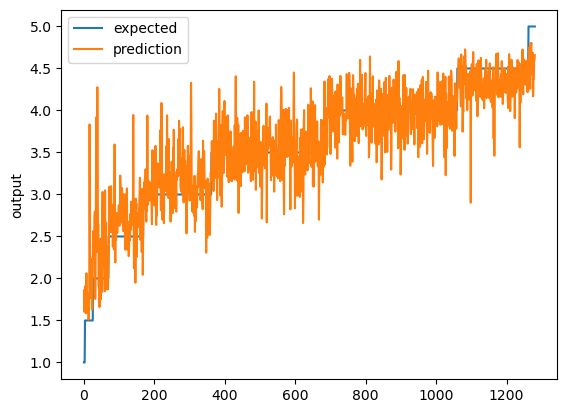

1. Business name: St Honore Pastries, Rating: 4.5, Predicted Rating: [2.7801218]
2. Business name: Denny's, Rating: 4.5, Predicted Rating: [4.4380503]
3. Business name: Zio's Italian Market, Rating: 4.5, Predicted Rating: [3.7757123]
4. Business name: Tuna Bar, Rating: 4.0, Predicted Rating: [4.0593734]
5. Business name: BAP, Rating: 3.5, Predicted Rating: [3.0042734]


In [25]:
# Get best model results
rmse = model_results['rmse'][19]
pred = model_results['pred'][19]

print("Score (RMSE): {}".format(rmse))
chart_regression(pred.flatten(),y_test)

for i in range(5):
    print("{}. Business name: {}, Rating: {}, Predicted Rating: {}".format(i+1,business.iloc[i]['name'],y[i],pred[i]))